# Hernquist model + central black hole, at equilibrium

Hernquist two-power model spherical galaxy (Binney \& Tremaine, 2008):

$$\rho(r)=\frac{M}{2\pi a^3}\frac{1}{r\left(1+\frac{r}{a}\right)^3}$$

**Equilibrium**

For most practical uses stellar systems are approximated collisionless: star's orbits can be described as if the potential is generated by the smooth mass density distribution rather than each point-like source individually. The collisionless approximation holds as long as the system evolves for a time shorter than the relaxation time: 

$$t_{relax}=\frac{0.1N}{\ln{N}}t_{cross}$$

where $t_{cross}$ is the typical dynamical timescale of the galaxy (the time it takes a typical star to complete one orbit around the system). In any collisionless system it is usefull to define the distribution function (DF). It expresses at any time $t$ the probability of finding a randomly chosen star at point $\boldsymbol{w}=(\boldsymbol{x},\boldsymbol{v})$ in phase space: 

$$\int d^3\boldsymbol{x} d^3\boldsymbol{v} f(\boldsymbol{x},\boldsymbol{v},t) = 1 $$
The DF satisfies the collisionless Boltzmann equation, which represents the conservation of probability in phase space, analogous to how the continuity equation represents mass conservation:

$$  \frac{\partial f}{\partial t} + \frac{\partial}{\partial \boldsymbol{w}}\cdot (f\dot{\boldsymbol{w}}) = 0$$

Jeans theorem states that a solution of the collisionless Boltzmann equation is steady if and only if it depends on the phase space coordinates only through integrals of motion in the given potential. 
In any steady state potential $\Phi(\boldsymbol{x})$ the energy $H = \frac{1}{2}v^2 + \Phi(\boldsymbol{x})$ is an integral of motion. All stellar systems which DF is a function of the energy only are at equilibrium and are called ergodic. It's easy to prove that the mean velocity vanishes everywhere and the velocity dispersion is isotropic:

$$ \sigma_{ij}^2 = \overline{v_iv_j}-\overline{v_i}\, \overline{v_j}=\overline{v_iv_j}=\sigma^2\delta_{ij}$$

A self-consistent system is a system which density distribution generates the potential through Poisson's equation and the potential determines the density according to the collisionless Boltzmann equation. Hernquist mass distribution has spherical symmetry so it's most conveniently described by spherical coordinates. It's useful to define new variables:

$$\Psi = -\Phi + \Phi_0  \quad \quad  \mathcal{E} = -E + \Phi_0 = \Psi - \tfrac{1}{2}v^2$$

$\Phi_0$ is chosen such that $f>0$ if $\mathcal{E}>0$ and $f=0$ if $\mathcal{E}\leq 0$. For an isolated system, $\Phi_0=0$ and the relative energy is equal to the binding energy. With this new coordinates Poisson's equation simply reads: $\nabla^2 \Psi = -4\pi G \rho$.
If the system is ergodic mass density satisfies:

$$\nu(r)=\frac{\rho(r)}{M} = \int_0^{\sqrt{2\Psi}} dv 4\pi v^2 f(\Psi-\tfrac{1}{2} v^2)= 4\pi \int_0^{\sqrt{2\Psi}} d\mathcal{E} f(\mathcal{E})\sqrt{2(\Psi-\mathcal{E})}$$

Expressing $\rho$ as a function of $\Psi$ ($\Psi$ is a monotonic function of $\nu$): 

$$    \frac{1}{\sqrt{8}\pi}\nu(\Psi)=2 \int_0^{\Psi} d\mathcal{E} f(\mathcal{E})\sqrt{\Psi-\mathcal{E}}$$

differentiating left and right and recognizing the resulting Abel integral equation, we finally get the Eddington formula, that permits to find a consistent DF for the given spherical distribution and potential: 

$$    f(\mathcal{E})=\frac{1}{\sqrt{8}\pi^2}\frac{d}{d\mathcal{E}}\int_0^{\mathcal{E}} \frac{d\Psi}{\sqrt{\mathcal{E}-\Psi}}\frac{d\nu}{d\Psi}$$
The only constrain is that the solution $f(\mathcal{E})$ must be nowhere negative and this happens only if the integral over energies in the Eddington formula is an increasing function of $\mathcal{E}$. 

Inverse sampling:



In [1]:
from myTreecode import Star
from myTreecode import Tree
from myTreecode import grav_force_star_node
from myTreecode import evolve
from view import view

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [2]:
time_conversion_factor = 0.067069       # 1 Myr in internal units
energy_conversion_factor = 1/1524.834   # sun kinetic energy in internal units
velocity_conversion_factor = 15.248335  # Km/s in internal units

In [3]:
class Hernquist:
    
    def __init__(self,N,a,m=1,M_bh=0,plot=False):
        self.N = int(N) 
        self.a = a 
        self.m = m 
        self.M = N*self.m 
        self.rho0 = self.M / (2*np.pi*self.a**3) 
        self.M_bh = M_bh

        
        print(f"Hernquist model of {self.N} stars and total mass {self.M:.2f} solar masses. "
              f"Scale parameter a is {self.a:.2f} parsecs.")
        if M_bh > 0: print(f"Central black hole of mass {M_bh:.2f}")

        self.v_typical = np.sqrt(self.M / self.a)  # from virial theorem
        self.t_cross = self.a / self.v_typical        
        self.t_relax = (0.1 * self.N / np.log(self.N)) * self.t_cross

        print(f"Characteristic velocity is {self.v_typical:.2e} in internal units, "
              f"{self.v_typical * velocity_conversion_factor:.2e} km/s. ")
        print(f"Crossing time is {self.t_cross:.2e} in internal units, "
              f"{self.t_cross * time_conversion_factor:.2e} Myr. "
              f"Relaxation time is {self.t_relax:.2e} in internal units, "
              f"{self.t_relax * time_conversion_factor:.2e} Myr.")


        ### initialize arrays for numeric DF calculation ###
  
        r_array = np.logspace(-4,4,100000) * self.a  
        nu = self.rho0 / self.M / ((r_array/a) * (1+r_array/a)**3)      # mass probability distribution
        Psi = self.M / self.a / (1+r_array/a)  +  self.M_bh/r_array     # potential
        nu = nu[::-1] 
        Psi = Psi[::-1]
        dnu_dPsi = np.gradient(nu, Psi)
        
        E_array = np.logspace(np.log10(min(Psi)), np.log10(max(Psi)),1000) 
        
        Y = []
        for E in E_array: 
            Y.append(quad(lambda psi: np.interp(psi, Psi, dnu_dPsi) / np.sqrt(E - psi), 0, E)[0])

        DF_num = 1/(2**(3/2) * np.pi**2) * np.gradient(Y,E_array)
        DF_fun = interp1d(E_array, DF_num, kind='cubic', fill_value="extrapolate")

        if plot:
            plt.plot(E_array,DF_fun(E_array))
            
            #plt.plot(E_array/(self.M/self.a), np.log10((self.M*self.a)**(3/2) * DF_fun(E_array)))
            plt.xlabel("$\mathcal{E}/(GM/a)$")
            plt.ylabel("log$[(GMa)^{3/2}f]$")
            
            plt.xscale("log")
            plt.yscale("log")

        #F = [0] 
        #for k in range(1,len(E_array)):
        #    F.append(F[k-1] + quad(lambda e: DF_fun(e),E_array[k-1],E_array[k])[0])

        #inverse_integral = interp1d(F,E_array,kind='linear')
        # compute integral for inverse sampling
        #F = []
        #for E in E_array:
        #    F.append(quad(lambda e: DF_fun(e), 0, E)[0])

        #inverse_integral = interp1d(F,E_array, kind='cubic', fill_value="extrapolate")
            

        #plt.plot(E_array, F) #inverse_integral(E_array))
        #plt.xlim(20,30)
        #plt.ylim(0.001,1)
        
        
        
        # initialize system
        
        self.t = [0]
        self.system = []

        initial_conditions = []

        for i in range(N):
            
            #inizialize position 
            
            m_r = random.uniform(0,self.M)
            x = 2 * np.pi * self.rho0 * self. a / m_r
            y = 1 / self.a
            r = (-y-np.sqrt(x))/(y**2-x) 
            #self.R.append(r)
            #v_circ = np.sqrt( M * (r/a)**2 /(2*(1+r/a)**2) / r + M_bh/r )
            #self.V_circ.append(v_circ)
            #self.t_orbit.append(2*np.pi*r/v_circ)
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)
            x = np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])

            # initialize velocity

            # inverse sampling
            Psi_particle = self.M/(self.a + r) + self.M_bh / r
            E_array = np.linspace(0,Psi_particle,100)

            F = [0] 
            for k in range(1,len(E_array)):
                F.append(F[k-1] + quad(lambda e: 4*np.pi * DF_fun(e) * np.sqrt(2 * (Psi_particle - e)), E_array[k-1],E_array[k])[0])

            inverse_integral = interp1d(F,E_array,kind='linear')#,fill_value="extrapolate")

            nu_r = self.rho0 / (r/self.a*(1+r/self.a)**3) / self.M  
            F_e = random.uniform(0,nu_r)
            if y < max(F):
                E = inverse_integral(F_e) 
            else:
                E = inverse_integral(max(F)) 
                
            v_magn = np.sqrt(2*(Psi_particle - E))
            
            #print(Psi_particle)
            #print(E)
            
            #initialize velocity
            
            #Psi_particle = self.M/(self.a+r) + self.M_bh/r
            #v_max = np.sqrt(2*Psi_particle)
            #v_array = np.arange(0,v_max,v_max/100) 
            
            #def integranda(v):
            #    E = Psi_particle - 1/2 * v**2
            #    return 4*np.pi*v**2 * DF_fun(E) 

            #AA = [0] 
            #for k in range(1,len(v_array)):
            #    AA.append(AA[k-1] + quad(integranda,v_array[k-1],v_array[k])[0] )

            #inversion_interpolation = interp1d(AA,v_array,kind='linear')

            #nu_r = self.rho0/(r/self.a*(1+r/self.a)**3) / self.M  
            #y = random.uniform(0,nu_r) 
            #if y < max(AA):
            #    v = inversion_interpolation(y) 
            #else:
            #    v = inversion_interpolation(max(AA)) 
            
            #v_magn = np.sqrt(2*(Psi_particle - E))
            #v_magn = v

            #print(v_magn)
            
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)

            v = np.array([v_magn*np.sin(theta)*np.cos(phi),v_magn*np.sin(theta)*np.sin(phi),v_magn*np.cos(theta)])

            initial_conditions.append(Star(self.m, x, v))
        
        self.system.append(np.array(initial_conditions))
            

Hernquist model of 1000 stars and total mass 1000.00 solar masses. Scale parameter a is 100.00 parsecs.
Characteristic velocity is 3.16e+00 in internal units, 4.82e+01 km/s. 
Crossing time is 3.16e+01 in internal units, 2.12e+00 Myr. Relaxation time is 4.58e+02 in internal units, 3.07e+01 Myr.


/tmp/ipykernel_28268/1029576111.py:41: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Y.append(quad(lambda psi: np.interp(psi, Psi, dnu_dPsi) / np.sqrt(E - psi), 0, E)[0])


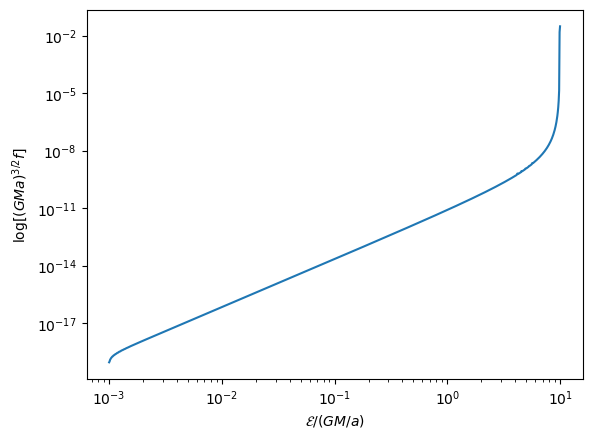

In [4]:
hern = Hernquist(N=1000,a=100,m=1,plot=True)

In [12]:

evolve(hern,tstop = 1000,dt = 100,dtout=300,eps=0.001,orbit_indexes=[20,60,70,1,2,3])

Evolving system:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
print(hern.t)
print(hern.t_orbits)

[0, 1.0999999999999999, 2.1000000000000005, 3.1000000000000014, 4.100000000000001, 5.1999999999999975, 6.299999999999994, 7.39999999999999, 8.499999999999986, 9.599999999999982, 309.59999999999997, 709.5999999999999]
[9.599999999999982, 109.59999999999998, 209.59999999999997, 309.59999999999997, 409.59999999999997, 509.59999999999997, 609.5999999999999, 709.5999999999999, 809.5999999999999, 909.5999999999999]


In [14]:
print(hern.t)
print(hern.t_orbits)

[0, 1.0999999999999999, 2.1000000000000005, 3.1000000000000014, 4.100000000000001, 5.1999999999999975, 6.299999999999994, 7.39999999999999, 8.499999999999986, 9.599999999999982, 309.59999999999997, 709.5999999999999]
[9.599999999999982, 109.59999999999998, 209.59999999999997, 309.59999999999997, 409.59999999999997, 509.59999999999997, 609.5999999999999, 709.5999999999999, 809.5999999999999, 909.5999999999999]


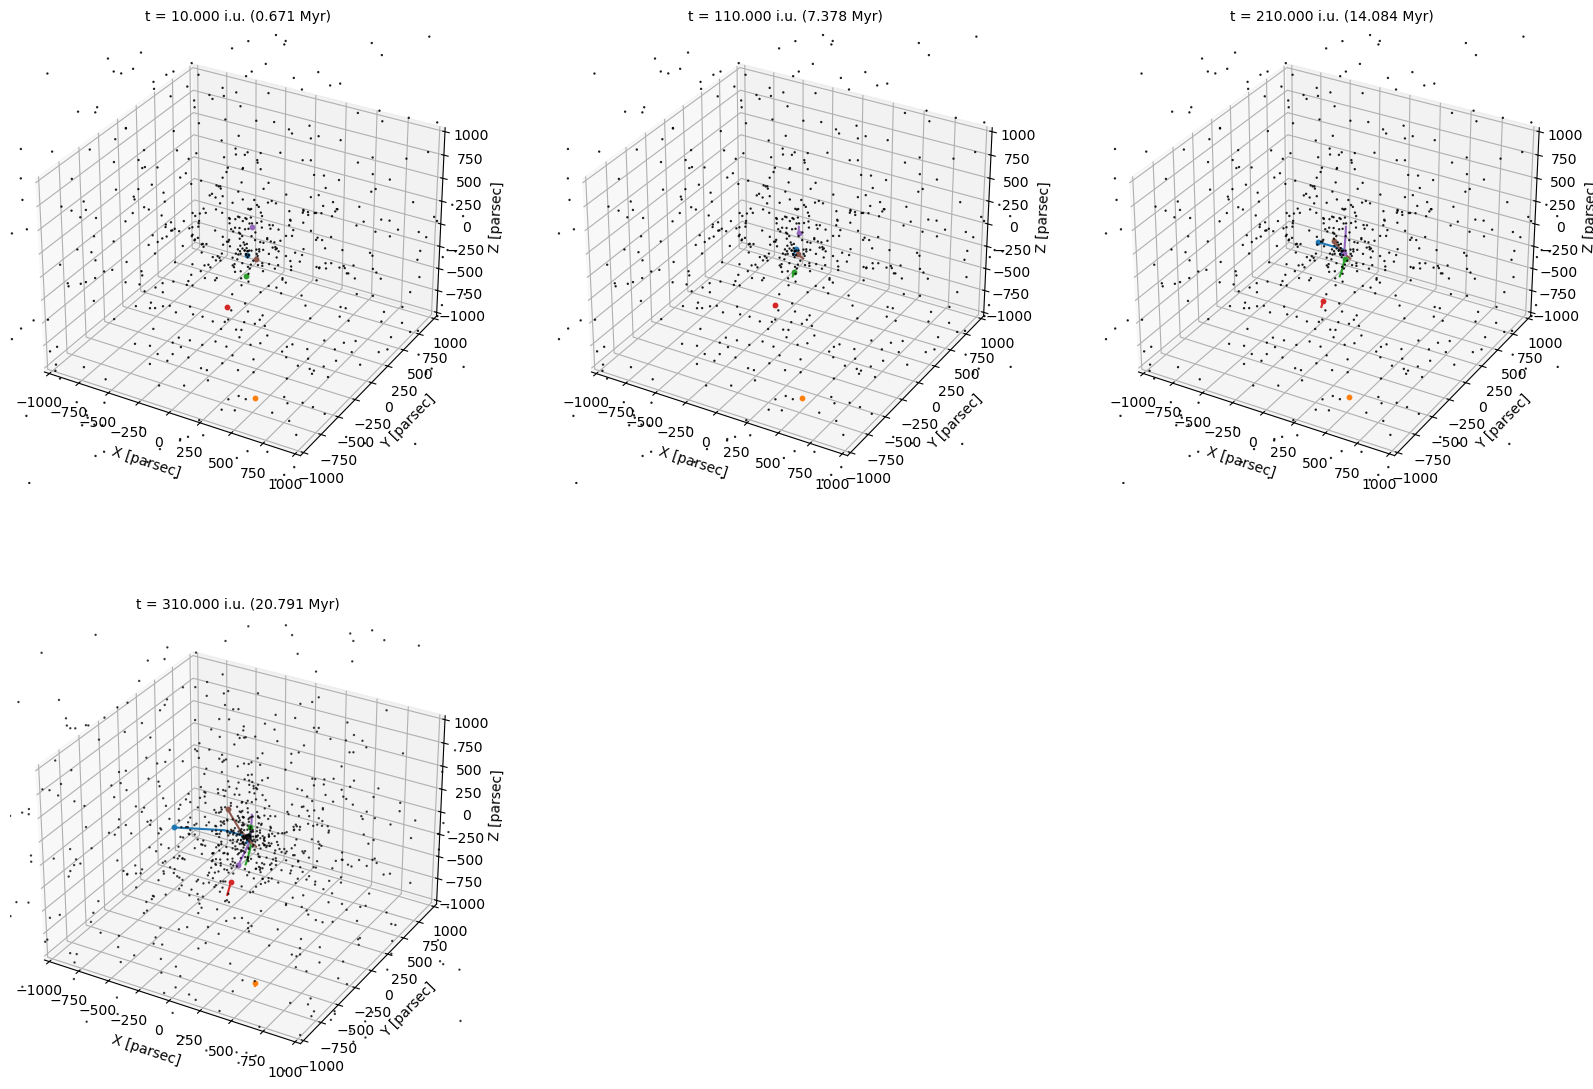

In [30]:
view(hern,r_max=1000, t=[10,110,210,310],orbit_indexes=[20,60,70,1,2,3])

In [10]:
print(hern.orbits[0])

[array([ 77.35649786, -98.21754771,  43.7836178 ]), array([ 77.35645696, -98.21745554,  43.7835937 ]), array([ 77.35633424, -98.21717905,  43.78352138]), array([ 77.35612973, -98.21671822,  43.78340086]), array([ 77.3558434 , -98.21607306,  43.78323213]), array([ 77.35547526, -98.21524356,  43.78301518]), array([ 77.35502532, -98.21422973,  43.78275003]), array([ 77.35449357, -98.21303155,  43.78243667]), array([ 77.35388   , -98.21164903,  43.78207509]), array([ 77.35318463, -98.21008215,  43.78166531]), array([ 77.35240744, -98.20833092,  43.78120731]), array([ 77.35154844, -98.20639532,  43.78070111]), array([ 77.35060762, -98.20427534,  43.78014669]), array([ 77.34958498, -98.20197099,  43.77954406]), array([ 77.34848053, -98.19948225,  43.77889322]), array([ 77.34729425, -98.19680911,  43.77819417]), array([ 77.34602615, -98.19395155,  43.7774469 ]), array([ 77.34467618, -98.19090955,  43.7766514 ]), array([ 77.34324429, -98.18768306,  43.77580763]), array([ 77.34173048, -98.18427

In [56]:
print(len(hern.system))
print(hern.t)
print(hern.t_orbits)

12
[0, 0.30000000000000004, 0.7, 6, 11, 16, 21, 26, 31, 36, 41, 46]
[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
class Hernquist(Galaxy):

    def __init__(self,N,a=10,M_bh=0,m=1,plot=False): 
        self.N = N ; self.a = a ; self.M_bh = M_bh ; self.m = m ; M = N*m ; self.M = M
        rho0 = M/(2*np.pi*a**3) 
        super().__init__(N) 
        print("Hernquist galaxy of %i stars of mass %.2f. Central density is %.2f solar masses for parsec cube, scale parameter a is %.2f parsecs" %(N, m, rho0, a))
        if M_bh>0: print("Central black hole of mass %.2f" %M_bh)

        r_array = np.logspace(-4,4,100000) * self.a  
        nu = self.rho0 / self.M / ((r_array/a) * (1+r_array/a)**3)      # mass probability distribution
        Psi = self.M / self.a / (1+r_array/a)  +  self.M_bh/r_array     # potential
        nu = nu[::-1] 
        Psi = Psi[::-1]
        #dnu_dPsi = np.diff(nu) / np.diff(Psi)
        #Psi = Psi[:-1]
        dnu_dPsi = np.gradient(nu, Psi)

        def integrand(psi,E): 
            return np.interp(psi, Psi, dnu_dPsi) / np.sqrt(E - psi)

        E_array = np.logspace(np.log10(min(Psi)), np.log10(max(Psi)),1000) 
        
        Y = []
        for E in E_array: 
            Y.append(integrate.quad(integrand, 0, E, args=(E))[0])
        
        dY_dE = np.diff(Y)/np.diff(E_array)
        self.E_array = E_array[:-1]
        self.dY_dE = dY_dE

        def integrand(psi,E): 
            return np.interp(psi, Psi, dnu_dPsi)/np.sqrt(E-psi)
                            
        E_array = np.logspace(np.log10(min(Psi)), np.log10(max(Psi)),1000) 
          
        Y = []
        for E in E_array: 
            Y.append(integrate.quad(integrand, 0, E, args=(E))[0])
        
        dY_dE = np.diff(Y)/np.diff(E_array)
        self.E_array = E_array[:-1]
        self.dY_dE = dY_dE

        def DF_num(E): 
            return 1/(2**(3/2) * np.pi**2) * np.interp(E, self.E_array, self.dY_dE) 
            
        def DF_an(E):
            E_tilde = E /(M/a) 
            return 1/(np.sqrt(2)*(2*np.pi)**3 *(M*a)**(3/2) ) * np.sqrt(E_tilde)/(1-E_tilde)**2 *( (1-2*E_tilde)*(8*E_tilde**2-8*E_tilde-3) +3*np.arcsin(np.sqrt(E_tilde))/np.sqrt(E_tilde*(1-E_tilde)))

        
        ### initialize system ###
        
        initial_system = [] ; self.R = [] ; self.V = [] ; self.V_circ = [] ; self.t_orbit = [] ; self.E = [] ; self.L = [] ; self.Lz = []

        if M_bh>0:
            initial_system.append(Star(M_bh,np.array([0,0,0]),np.array([0,0,0])))
            self.perturber_index.append(0)
            self.N = N + 1

        for i in tqdm(range(N)):
            
            #inizialize position 
            
            m_r = random.uniform(0,self.M)
            x = 2*np.pi*rho0*a/m_r
            y = 1/a
            r = (-y-np.sqrt(x))/(y**2-x) 
            self.R.append(r)
            v_circ = np.sqrt( M * (r/a)**2 /(2*(1+r/a)**2) / r + M_bh/r )
            self.V_circ.append(v_circ)
            self.t_orbit.append(2*np.pi*r/v_circ)
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)
            pos_cart = np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])

            #initialize velocity
            
            Psi_particle = M/(a+r) + M_bh/r
            v_max = np.sqrt(2*Psi_particle)
            v_array = np.arange(0,v_max,v_max/100) 
            
            def integrand(v):
                E = Psi_particle - 1/2 * v**2
                return 4*np.pi*v**2 * DF_num(E) 

            integral = [0] 
            for k in range(1,len(v_array)):
                integral.append(integral[k-1]+integrate.quad(integrand,v_array[k-1],v_array[k])[0])

            inversion_interpolation = scipy.interpolate.interp1d(integral,v_array,kind='linear')

            nu_r = rho0/(r/a*(1+r/a)**3) / M  
            y = random.uniform(0,nu_r) 
            if y < max(integral):
                v = inversion_interpolation(y) 
            else:
                v = inversion_interpolation(max(integral)) 
            
            #initialize velocity
            
            #Psi_particle = M/(a+r) + M_bh/r
            #v_max = np.sqrt(2*Psi_particle)
            #v_array = np.arange(0,v_max,v_max/100) 
            
            #def integrand(v):
            #    E = Psi_particle - 1/2 * v**2
                return 4*np.pi*v**2 * DF_num(E) 

            integral = [0] 
            for k in range(1,len(v_array)):
                integral.append(integral[k-1]+integrate.quad(integrand,v_array[k-1],v_array[k])[0])

            inversion_interpolation = scipy.interpolate.interp1d(integral,v_array,kind='linear')

            nu_r = rho0/(r/a*(1+r/a)**3) / M  
            y = random.uniform(0,nu_r) 
            if y < max(integral):
                v = inversion_interpolation(y) 
            else:
                v = inversion_interpolation(max(integral)) 
            self.V.append(v)
            self.E.append(Psi_particle - 1/2 * v**2)

            theta_v = np.arccos(1-2*random.uniform(0,1))
            phi_v = 2*np.pi*random.uniform(0,1)
            vel_cart = np.array([v*np.sin(theta_v)*np.cos(phi_v),v*np.sin(theta_v)*np.sin(phi_v),v*np.cos(theta_v)])
            l = self.m * np.cross(pos_cart,vel_cart)
            self.Lz.append(l[2])
            self.L.append(np.sqrt(l[0]**2+l[1]**2+l[2]**2))
            
            initial_system.append(Star(self.m,pos_cart,vel_cart))

        self.R = np.array(self.R) ; self.V = np.array(self.V) ; self.V_circ = np.array(self.V_circ) ; self.E = np.array(self.E) ; self.L = np.array(self.L) ; self.Lz = np.array(self.Lz)
        self.n_body_system.append(np.array(initial_system))

        #t_dynamical t_cross and t_relax
        self.r_median = np.median(self.R) ; self.v_median = np.median(self.V)
        self.t_cross = self.r_median/self.v_median
        self.t_relax = (0.1*N/np.log(N))*self.t_cross
        print("t_cross time is %f in internal units, %f Myr. t_relax time is %f in internal units, %f Myr" %(self.t_cross, self.t_cross*time_conv,self.t_relax, self.t_relax*time_conv))



In [4]:
#functions and observatives

def DF_num(hern,E): 
    return 1/(2**(3/2) * np.pi**2) * np.interp(E, hern.E_array, hern.dY_dE) 

def DF_an(E,M,a):
    E_tilde = E /(M/a) 
    return 1/(np.sqrt(2)*(2*np.pi)**3 *(M*a)**(3/2) ) * np.sqrt(E_tilde)/(1-E_tilde)**2 *( (1-2*E_tilde)*(8*E_tilde**2-8*E_tilde-3) +3*np.arcsin(np.sqrt(E_tilde))/np.sqrt(E_tilde*(1-E_tilde)))

def rho(r,M,a):
    rho0 = M/(2*np.pi*a**3)
    return rho0/(r/a*(1+r/a)**3)

def potential(r,M,a,M_bh):
    return -M/(r+a) - M_bh/r

def v_circ(r,M,a,M_bh):
    return  np.sqrt(M * (r/a)**2 /(2*(1+r/a)**2) / r + M_bh/r)

def surface_brightness(R,mass_light_ratio,M,a): 
    return (2/mass_light_ratio) * integrate.quad(lambda r: rho(r,M,a) * r /(r**2-R**2)**(1/2), R, np.inf)[0]  

def sigma_r(r,M,a,M_bh):  
    mu = M_bh/M
    x = r/a
    y = 1 + x
    return np.sqrt((M/a)*((1+6*mu)*x*y**3 *np.log(y/x) - mu*y**3*(3*x-1/2)/x - x*(1/4+1/3*y+(1+mu)/2*y**2+(1+3*mu)*y**3)/y))
    
def sigma_LOS(R,M,a,M_bh):
    rho_norm = integrate.quad(lambda r: rho(r,M,a) * r /(r**2-R**2)**(1/2), R, np.inf)[0]
    return np.sqrt(1/rho_norm * integrate.quad(lambda r: rho(r,M,a) * sigma_r(r,M,a,M_bh)**2 *r /(r**2-R**2)**(1/2), R, 1.e3*a)[0])
        

In [27]:
#print(surface_brightness(0.01,1,10000,10))

194.1983791356841


In [48]:
#print(sigma_LOS(2.9,10000,10,200)*velocity_conv)

164.60496344303414


In [14]:
### check sampling ###

def sample_test(hern,time=0,filename=None):

    if time > hern.t[-1]: time=hern.t[-1] 
    frame = np.digitize(time,hern.t)-1
        
    M, a, M_bh, rho0 = hern.M, hern.a, hern.M_bh, hern.M/(2*np.pi*hern.a**3)

    R_sampled = [] ; E_sampled = [] ; L_sampled = []
    for star in hern.n_body_system[frame]:  
        if not star.r == 0: #exclude black hole
            R_sampled.append(star.r)
            E_sampled.append(M/(star.r+a) + M_bh/star.r-1/2*star.v**2)
            l = np.cross(star.position,star.velocity)
            L_sampled.append(np.sqrt(l[0]**2+l[1]**2+l[2]**2))
    R_sampled = np.array(R_sampled) ; E_sampled = np.array(E_sampled) ; L_sampled = np.array(L_sampled)


    ###  histograms  ###
    
    fig_h, axes_h = plt.subplots(1,2, figsize=(8,4),layout="constrained") 

    axes_h[0].hist(np.log10(R_sampled/hern.a), bins=20, color = "red", ec="black") 
    axes_h[1].hist(np.log10(E_sampled[np.log10(E_sampled/(hern.M/hern.a))>-4]/(hern.M/hern.a)),bins=20, color = "blue", ec="black")

    #axes_h[1].set_xlim(-4,np.log10(max(E_sampled/(hern.M/hern.a))))
    axes_h[0].set_xlabel("log(r/a)")
    axes_h[1].set_xlabel("log($\mathcal{E}/(GM/a))$")
    axes_h[0].set_ylabel("#")
    axes_h[1].set_ylabel("#")
    axes_h[0].text(.65,0.98,"$N=1000$ \n a = 10 pc \n $M_{\\bullet}=10^3 M_\odot$",fontsize=12, ha='left', va='top', transform=axes_h[0].transAxes)
    
    plt.savefig("%s_hist.png")

    
    #r array

    #print(min(L_sampled))
    #print(np.percentile(L_sampled,90))
    #print(max(L_sampled))


    ###  distributions  ###
    
    R_array = np.logspace(np.log10(min(R_sampled)),np.log10(max(R_sampled)),11)
    E_array = np.logspace(np.log10(1.e-1*M/a),np.log10(max(E_sampled)),11)
    L_array = np.logspace(np.log10(min(L_sampled)),np.log10(max(L_sampled)),11) #11
    
    #mass distribution
    
    R_hist = np.histogram(R_sampled, bins=R_array) 
    R_bin = [] ; R_dens = [] ; R_err = []
    for i in range(len(R_hist[1])-1):
        if R_hist[0][i] > 0:
            R_bin.append((R_hist[1][i]+R_hist[1][i+1])/2)
            V = 4/3 * np.pi * (R_hist[1][i+1]**3 - R_hist[1][i]**3) 
            R_dens.append(R_hist[0][i] / V)
            R_err.append(1/np.sqrt(R_hist[0][i])) 
    R_bin = np.array(R_bin) ; R_dens = np.array(R_dens); R_err = np.array(R_err)

    
    #energy distribution

    def integrand(r,E):
        return 16 * np.pi**2 * r**2 * np.sqrt(2* (M/(r+a) + M_bh/r - E) ) if  M/(r+a) + M_bh/r >= E else 0
 
    E_hist = np.histogram(E_sampled, bins=E_array)  
    E_bin = [] ; E_dens = [] ; E_err = []
    for i in range(len(E_hist[1])-1):
        if E_hist[0][i] > 0:
            E_bin.append((E_hist[1][i]+E_hist[1][i+1])/2)

            V = integrate.quad(lambda E : integrate.quad(integrand,0,np.inf,args=(E))[0],E_hist[1][i],E_hist[1][i+1])[0]  
            #V = density_of_states[i]*(E_hist[1][i+1]-E_hist[1][i]) 
            
            E_dens.append(E_hist[0][i] / V /hern.N)  #justify division by N
            E_err.append(1/np.sqrt(E_hist[0][i])) #/V
    E_bin = np.array(E_bin) ; E_dens = np.array(E_dens); E_err = np.array(E_err)

    
    #angular momentum distribution
    
    #def integrand(r,v,theta,L1,L2):
    #    if L1 < np.abs(r*v*np.sin(theta)) < L2:
    #        return 16*np.pi**2*r**2*v**2
    #    else:
    #        return 0
    
    #ranges = [[0,np.inf],[0,np.inf],[0,np.pi/2]]
    #opts = [{'epsabs': 1.e-02, 'epsrel': 1.e-02, 'limit': 20}] * 3
    #2* integrate.nquad(integrand,ranges=ranges,args=(L_hist[1][i],L_hist[1][i+1]),opts=opts)[0] 
    #V = [309919364987.23224, 6833961109819.854, 1402080244378.6428, 4600635639548.699, 12420201992265.586, 36075819096124.58, 501985441027854.75, 1782498182716797.8, 6645092272829377.0, 2.660847277585077e+16]
    #V = [2489866652425.465, 497872376602.45483, 1265769219190.699, 13731989906869.781, 11135909813942.916, 40327936814827.01, 555826417045895.7, 1978513740055925.0, 7314601763605293.0, 2.64346354064617e+16]
    
    #L_hist = np.histogram(L_sampled, bins=L_array)  
    #L_bin = [] ; L_dens = [] ; L_err = [] ; #V = []
    #for i in tqdm(range(len(L_hist[1])-1)):
    #    if L_hist[0][i] > 0:
    #        L_bin.append((L_hist[1][i]+L_hist[1][i+1])/2)  
            #Vol = 2* integrate.nquad(integrand,ranges=ranges,args=(L_hist[1][i],L_hist[1][i+1]),opts=opts)[0] 
    #        L_dens.append(L_hist[0][i] / V[i] /hern.N)  #justify division by N
            #V.append(V[i])
    #        L_err.append(1/np.sqrt(L_hist[0][i])) #/V
    #L_bin = np.array(L_bin) ; L_dens = np.array(L_dens); #L_err = np.array(L_err)
    #print(L_dens)
    #
    #print(V)
    

    ### plots ###

    r_array_long = np.logspace(np.log10(min(R_sampled)),np.log10(max(R_sampled)),100)
    E_array_long = np.logspace(np.log10(1.e-1*M/a),np.log10(max(E_sampled)),100)
    
    fig, axes = plt.subplots(1,2, figsize=(8,4),layout="constrained") 
    
    axes[0].plot(np.log10(r_array_long/a),np.log10(rho(r_array_long,M,a)/rho0),c='red')
    axes[0].errorbar(np.log10(R_bin/a),np.log10(R_dens/rho0),yerr=R_err, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
    axes[0].set_xlabel("log($r/a$)")
    axes[0].set_ylabel("log($\\rho/\\rho_0$)")

    axes[1].plot(np.log10(E_array_long/(M/a)),np.log10(DF_num(hern,E_array_long)*(M*a)**(3/2) ),c='blue')  
    axes[1].errorbar(np.log10(E_bin/(M/a)),np.log10(E_dens*(M*a)**(3/2) ),yerr=3*E_err, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black') 
    axes[1].set_xlabel("log$[\mathcal{E}/(GM/a)]$")
    axes[1].set_ylabel("log$[(GMa)^{3/2}f]$")
    #axes[1].set_ylim(-4,2)

    #L_a = a*v_circ(a,M,a,M_bh)
    #axes[2].axhline(y = np.mean(L_dens),c='pink')  
    #axes[2].errorbar(np.log10(L_bin/L_a),np.log10(L_dens),yerr=0.1*L_dens, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black') 
    #axes[2].set_xlabel("log($L/L_a$)")
    #axes[2].set_ylabel("$dn(L)/d\Omega(L)$")

    if filename is not None: 
        plt.savefig("%s_distr.png")
    plt.show()
    

In [7]:
def jeans_hernquist(hern,r_max,dr,M_bh=[0],time=0,filename=None):

    jeans_virtual = jeans_spherical(hern,r_max,dr,time=time)
    r_sampled = jeans_virtual[0]
    R_sampled = jeans_virtual[1]
    sigma_r_sampled = jeans_virtual[2]
    error_sigma_r = jeans_virtual[3]
    sigma_LOS_sampled = jeans_virtual[4]
    error_sigma_LOS = jeans_virtual[5]


    fig, axes = plt.subplots(figsize=(5.5,4.5),layout="constrained") 
    #print("%.2f  + %.2f " %(sigma_LOS_sampled*velocity_conv,error_sigma_r*velocity_conv))
    
    #axes[0].errorbar(r_sampled/hern.a,sigma_r_sampled*velocity_conv,yerr=error_sigma_r*velocity_conv, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
    axes.errorbar(R_sampled/hern.a,sigma_LOS_sampled*velocity_conv,yerr=error_sigma_LOS*velocity_conv, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
    
    #axes[0].set_ylim(0.8*min(sigma_r_sampled*velocity_conv),2*max(sigma_r_sampled*velocity_conv))
    axes.set_ylim(0.8*min(sigma_LOS_sampled*velocity_conv),2*max(sigma_LOS_sampled*velocity_conv))
    
    #predicted curves
    #r = np.linspace(0,r_max+dr) 
    R = np.linspace(0,r_max+dr) 

    cmap = plt.get_cmap('rainbow', len(M_bh))

    for i in range(len(M_bh)): 
    
        r_dynamical = (1/hern.a - np.sqrt(2*np.pi*(hern.M/(2*np.pi*hern.a**3))*hern.a/M_bh[i]))/(1/hern.a**2-2*np.pi*(hern.M/(2*np.pi*hern.a**3))*hern.a/M_bh[i]) if M_bh[i] > 0 else 0
        #r_influence 
        
        sigma_LOS_pred = []
        for k in range(len(R)):
            sigma_LOS_pred.append(sigma_LOS(R[k],hern.M,hern.a,M_bh[i]))
        sigma_LOS_pred = np.array(sigma_LOS_pred)
        
        chi2_sum = 0
        ddof = len(sigma_LOS_sampled)-1
        for k in range(len(sigma_LOS_sampled)):
            #print("R = %.2f, %.2f-%.2f- error %.2f gives %.2f" %(R_sampled[k],sigma_LOS_sampled[k]*velocity_conv, np.interp(R_sampled[k],R,sigma_LOS_pred)*velocity_conv, error_sigma_LOS[k], (sigma_LOS_sampled[k]-np.interp(R_sampled[k],R,sigma_LOS_pred))**2/error_sigma_LOS[k]**2))
            chi2_sum = chi2_sum + (sigma_LOS_sampled[k]-np.interp(R_sampled[k],R,sigma_LOS_pred))**2/error_sigma_LOS[k]**2

        print("M_bh = %.2f : chi2 = %.2f, ddof = %i" %(M_bh[i],chi2_sum,ddof))

        #axes[0].plot(r/hern.a,sigma_r(r,hern.M,hern.a,M_bh[i])*velocity_conv, c = cmap(i), label="%i"%(M_bh[i])) 
        axes.plot(R/hern.a,sigma_LOS_pred*velocity_conv, c = cmap(i), label="%i, $\chi^2$ = %.1f"%(M_bh[i],chi2_sum))     
        if M_bh[i] > 0:
            #axes[0].axvline(x=r_dynamical/hern.a, linestyle=':', c = cmap(i)) 
            axes.axvline(x=r_dynamical/hern.a, linestyle=':', c = cmap(i)) 
            #axes[1].axvline(x=r_influence/hern.a, linestyle=':', c='black')
    
    #axes[0].set_xscale('log')
    axes.set_xscale('log')
    #axes[0].set_yscale('log')
    axes.set_yscale('log')
    
    #axes[0].set_ylabel("$\sigma_r$ [km/s]")
    axes.set_ylabel("$\sigma_\parallel$ [km/s]")
    #axes[0].set_xlabel("$r/a$")
    axes.set_xlabel("$R/a$")

    axes.legend(title = "$M_{bh}/M_\odot$",loc="upper right")
    axes.text(.01,.2,"$M_{gal} = 10^{%i} M_\odot$ \n a = %.1f pc \n $M_{\\bullet}=10^{%i} M_\odot$" %(np.log10(hern.M),hern.a,np.log10(hern.M_bh)),fontsize=12, ha='left', va='top', transform=axes.transAxes)

    if filename is not None: 
        plt.savefig(filename)
    plt.show()


Given a minimum sensitivity of an instrument of angular resolution A (in arcsec$^2$), what is the minimum number of stars that must fall in each bin in order to produce a signal? Suppose each star is $1 L_\odot$, and located at distance $d$. The flux is: 

$$F = \frac{L_\odot}{4\pi d^2}$$

and the surface brightness is: 

$$B = \frac{F}{A}$$ (in erg/s/cm$^2$/arcsec$^2$). The minimum number of stars of $1L_\odot$ to produce the minimum flux is:

$$N_{\odot,min} = \frac{F_{min}}{F_\odot} = \frac{F_{min}}{L_\odot} 4\pi d^2 $$

in terms of Flux. In terms of surface brightness: 

$$N_{\odot,min} = \frac{B_{min}}{F_\odot/A} = \frac{B_{min}}{L_\odot} 4\pi d^2 A $$

in terms of surface brightness, integration time, mass-to-light ratio

$$N_{\odot,min} = \frac{B_{min,1h}/t_{obs}}{M_*/\Upsilon} 4\pi d^2 A$$



In [17]:
A = 1 #arcsec^2
t_obs = 1 #hours
d = 1.e6 #pc
d_cm = d / 3.24078e-19
F_min = 3.6e-29 #erg cm^-2 s^-1 Hz^-1 sensitivity flux for SDSS in r band
L_sun_r = 6.5e32/(0.7e14) #erg/s/Hz luminosity of sun in r band per Hz
F_min_sun = F_min/L_sun_r
B_min = F_min_sun/A
N_min = B_min / t_obs * 4*np.pi * d_cm**2 * A
#print("Minimum number of stars that must fall in each 1 arcsec^2 bin is: %f" %N_min)

3.876923076923077e-48
Minimum number of stars that must fall in each 1 arcsec^2 bin is: 46.387178


In [64]:


def observation_hernquist(hern,model=None,time=0,
                          i=0,alpha=0,gamma=0,distance=1000,
                          angular_resolution=1,FOV=1.e3, 
                          sensitivity = 3.6e-29, saturation = 3.6e-20, exposure_h = 1,
                          spectral_resolution=2000, spectral_saturation = 500,
                          filename=None):

    #distance in pc, angular resolution and FOV in arcsec, sensitivity (in r band) in erg/s/cm^2/Hz/arcsec (SDSS), exposure in hours
    #spectral resolution adimensional, spectral saturation in km/s
    
    if model == None: model = [hern.M,hern.a,hern.M_bh,1] #hern.mass_light_ratio = 1
    mass_light_ratio = 1

    angular_conv = 206265/distance    #arcsec  converts distances in angular spearation in the sky, in arcsec
    A = angular_resolution**2         #area of 1 bin
    distance_cm = distance/ 3.24078e-19  #distance in cm
    L_sun_r = 6.5e32/(0.7e14) #erg/s/Hz specific luminosity of sun in r band 
    B_min_sun_r = sensitivity/L_sun_r/A  #sensitivity in units of specific Sun luminosity in r band
    B_max_sun_r = saturation/L_sun_r/A
    
    #check mass to light! 
    
    n_surface_bright_min = B_min_sun_r / exposure_h /(hern.m/mass_light_ratio) * 4*np.pi * distance_cm**2 * A       # minimum number of 1 solar mass stars that must fall in a bin of resolution to give a non zero signal
    n_surface_bright_max = B_max_sun_r / exposure_h /(hern.m/mass_light_ratio) * 4*np.pi * distance_cm**2 * A       #1 solar mass produces 1.e33 erg/s in r band, the minimum surface brightness detectable is 4.e-14 erg/s/arcsec corresponding to 10^19 solar type stars
    surface_brightness_conv = L_sun_r*(hern.m/mass_light_ratio)*exposure_h/(4*np.pi*distance_cm**2)
    
    print("Signal above threshold if more than %.1f stars/arcsec^2" %(n_surface_bright_min/A))
    print("Saturation point set at %1f stars/arcsec^2" %(n_surface_bright_max/A))
    
    delta_v_min = 2.99792458 * 10**5/velocity_conv / spectral_resolution               #minimum velocity detectable 
    delta_v_max = spectral_saturation/velocity_conv                                    #maximum velocity in km/s
    
    print("Minimum velocity detectable with given resolution is %.2f km/s" %(delta_v_min*velocity_conv))
    
    r_max = FOV/2 /angular_conv
    dr = angular_resolution/angular_conv
    print("R covered by FOV is %.2f pc, dr is %.2f pc"%(r_max,dr))

    ###  projection  ###

    sky_p = sky_projection(hern,r_max,dr,time,i,alpha,gamma)
    
    bins = [sky_p[0][0]*angular_conv, sky_p[0][1]*angular_conv]
    ra = np.array(sky_p[1])*angular_conv
    dec = np.array(sky_p[2])*angular_conv
    LOS_v_mean = sky_p[3]
    LOS_v_dispersion = sky_p[4]
    LOS_v_disp_errors = sky_p[5]

    ###  plot definition  ###

    fig, axes = plt.subplots(1, 3, figsize=(12,4),layout="constrained") 
    for i in range(3):
        axes[i].set_aspect('equal') 
        axes[i].set_xlabel("ra ['']") 
        axes[i].set_ylabel("dec ['']")

    
    #ticks
    
    R = np.array([0.1*hern.a,0.5*hern.a,hern.a,10*hern.a,50*hern.a,100*hern.a])
    SB_ticks = []
    sigma_LOS_ticks = []
    for r in R:
        if 2*dr < r < r_max: 
            sb_obs = surface_brightness(r,mass_light_ratio,M=hern.M,a=hern.a)
            sb_mod = surface_brightness(r,mass_light_ratio,M=model[0],a=model[1])
            sigma_obs = sigma_LOS(r,M=hern.M,a=hern.a,M_bh=hern.M_bh)
            sigma_mod = sigma_LOS(r,M=model[0],a=model[1],M_bh=model[2])
            print("R = %.1f pc" %r) 
            print("  SB_obs = %.1e, SB_model = %.1e    erg/s/cm^2/arcsec^2/Hz" %(sb_obs*surface_brightness_conv,sb_mod*surface_brightness_conv))
            print("  sigma_LOS_obs = %.1f, sigma_LOS_model = %1.f   km/s" %(sigma_obs*velocity_conv,sigma_mod*velocity_conv))
            SB_ticks.append(sb_obs)
            sigma_LOS_ticks.append(sigma_obs)

    SB_ticks = [sb for sb in SB_ticks if n_surface_bright_min <= sb <= n_surface_bright_max]
    sigma_LOS_ticks = [los for los in sigma_LOS_ticks if delta_v_min <= los <= delta_v_max]
    SB_ticks.append(n_surface_bright_min) ; SB_ticks.append(n_surface_bright_max) ; SB_ticks.sort()
    sigma_LOS_ticks.append(delta_v_min) ; sigma_LOS_ticks.append(delta_v_max) ; sigma_LOS_ticks.sort()

    #SURFACE BRIGHTNESS
    
    cmap = cm.rainbow
    cmap.set_under('w')  
    S = axes[0].hist2d(ra, dec, bins=bins,cmap=cmap,norm=mcolors.LogNorm(vmin=n_surface_bright_min,vmax=n_surface_bright_max)) 
    N = S[0]  
    cbar_sb = fig.colorbar(S[3], ax=axes[0], ticks=SB_ticks, location='bottom', label="surface brightness (r band) [erg/s/cm^2/Hz/arcsec$^2$]" )
    cbar_sb.set_ticklabels(["{:.1e}".format(i*surface_brightness_conv) for i in SB_ticks]) 
    

    #MEAN VELOCITY

    masked_LOS_v_mean = np.where((N < n_surface_bright_min) | (np.abs(LOS_v_mean) < delta_v_min), np.nan, LOS_v_mean)*velocity_conv
    cmap = cm.bwr #cm.spring
    cmap.set_bad(color='yellow')  
    
    V_mean = axes[1].imshow(masked_LOS_v_mean, interpolation='none', extent=[-FOV/2, FOV/2,-FOV/2, FOV/2],origin='lower',cmap=cmap)  
    fig.colorbar(V_mean, ax=axes[1], location='bottom', label="$v_\parallel [km/s]$") #mass_to_light_ratio
    
    #VELOCITY DISPERSION

    masked_LOS_v_dispersion = np.where((N < n_surface_bright_min) | (LOS_v_dispersion < delta_v_min), np.nan, LOS_v_dispersion)
    cmap = cm.viridis
    cmap.set_bad(color='white')  
    
    V_disp = axes[2].imshow(masked_LOS_v_dispersion, interpolation='none', extent=[-FOV/2, FOV/2,-FOV/2, FOV/2], origin='lower',cmap=cmap,vmin=delta_v_min, vmax = delta_v_max) #vmin=delta_v_min, vmax = delta_v_max #vmax=c_max_spec #aspect='auto' #norm=mcolors.LogNorm(vmin=c_min,vmax=c_max)
    cbar_V_disp = fig.colorbar(V_disp, ax=axes[2], ticks = sigma_LOS_ticks, location='bottom', label="$\sigma_\parallel [km/s]$") 
    cbar_V_disp.set_ticklabels(["{:.1f}".format(i*velocity_conv) for i in sigma_LOS_ticks])  

    for r in R:
        for i in range(3): 
            if 2*dr < r < r_max: 
                circle = plt.Circle((0, 0),r*angular_conv,linestyle=':',color='black', fill=False, linewidth=1.2)
                axes[i].add_patch(circle)
    
    if filename is not None: 
        plt.savefig(filename) 
    plt.show()


    

In [ ]:
    #r influence

    #R = np.linspace(1.e-5*r_dynamical,r_max,100)

    #R_ = np.logspace(np.log10(1.e-5*r_dynamical),np.log10(1.e-1*r_dynamical))
    #sigma_LOS_ = []

    #for i in range(len(R_)):
    #    sigma_LOS_.append(hern.sigma_LOS(R_[i],hern.M_bh))
    
    #print(hern.M_bh/(np.array(sigma_LOS_)*velocity_conv)**2)
    #axes[2].plot(R_/hern.a,R_/hern.a)
    #axes[2].plot(R_/hern.a,hern.M_bh/(np.array(sigma_LOS_)*velocity_conv)**2)
    
    
    #r_influence = np.interp(0, hern.M_bh/(np.array(sigma_LOS)*velocity_conv)**2 - R, R)
    #print(r_influence)
